# Livestock farms in Catalunya

### Table of content

* [1. Introduction](#1.-Introduction)
* [2. Data gathering](#2.-Data-Gathering)
* [3. Data assessment](#3.-Data-assessment)
    * [3.1. Quality issues](#3.1.-Quality-issues)
* [4. Data cleaning](#4.-Data-cleaning)
* [5. Data Analysis](#5.-Data-Analysis)
    * [5.1. What are the 5 most and least frequent animals in farms?](#5.1.-What-are-the-5-most-and-least-frequent-animals-in-farms?)
    * [5.2. Are there differences on animal species based on the province?](#5.2.-Are-there-differences-on-animal-species-based-on-the-province?)
    * [5.3. How many organic farms are and what are the most frequent species?](#5.3.-How-many-organic-farms-are-and-what-are-the-most-frequent-species?)
    * [5.4. Where are the organic farms located?](#5.4.-Where-are-the-organic-farms-located?)


# 1. Introduction
The dataset that will be wrangled and analysed is the register of livestock farms in Catalunya from the Dades Obertes de Catalunya (https://governobert.gencat.cat/ca/dades_obertes/). The dataset provides information about around 1,000 farms in 49 columns. The register is divided into different sections: beekeeping, poultry, pigs, rabbits, cattle, sheep and goats, horses, other productive species and centers for the collection of genetic material. Within each of the sections, the farms are classified into different subsections according to the productive purpose. More information about the dataset and the columns can be found here: https://analisi.transparenciacatalunya.cat/Medi-Rural-Pesca/Registre-d-explotacions-ramaderes/7bpt-5azk. 

The goal is to answer the following questions:
- What are the 5 most and least frequent animals in farms? 
- Are there differences on animal species based on the province?
- How many organic farms are and what are the most frequent species?
- Where are the organic farms located?

# 2. Data Gathering
In this part, the JSON containing the information will be downloaded to then continue with the wrangling and data analysis.

In [1]:
# Import necessary libraries
import geopandas as gpd
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from shapely.geometry import Point

Use the API link from Dades Obertes de Catalunya (https://analisi.transparenciacatalunya.cat/Medi-Rural-Pesca/Registre-d-explotacions-ramaderes/7bpt-5azk) to fetch the data. 

In [2]:
# Get JSON data and store it as a DataFrame
url = "https://analisi.transparenciacatalunya.cat/resource/7bpt-5azk.json"
df = pd.read_json(url)

In [3]:
# Visualize first rows
df.head()

marca_oficial       codi_rega estat_explotaci_ data_canvi_estat_explotaci_  \
0        0010AA  ES250010030750           Activa     1997-01-21T00:00:00.000   
1        0010AA  ES250010030750           Activa     1997-01-21T00:00:00.000   
2        0010AA  ES250010030750           Activa     1997-01-21T00:00:00.000   
3        0010AA  ES250010030750           Activa     1997-01-21T00:00:00.000   
4        0010AB  ES250010031100           Activa     1997-04-21T00:00:00.000   

             nom_explotaci adre_a_explotaci     cp servei_territorial  \
0  CASA JULIU - JORDI GASA      MASIA JULIU  25651             Lleida   
1  CASA JULIU - JORDI GASA      MASIA JULIU  25651             Lleida   
2  CASA JULIU - JORDI GASA      MASIA JULIU  25651             Lleida   
3  CASA JULIU - JORDI GASA      MASIA JULIU  25651             Lleida   
4             CASA GONELLA          BOIXOLS  25651             Lleida   

  demarcaci_territorial        comarca  ... cap_n_m_total_animals  \
0                Lleida  Pallars Jussà  ...                     0   
1                Lleida  Pallars Jussà  ...                     0   
2                Lleida  Pallars Jussà  ...                     0   
3                Lleida  Pallars Jussà  ...                     0   
4                Lleida  Pallars Jussà  ...                     0   

   total_cap_ponedores  total_ub total_nitrogen data_actualitzaci_capacitat  \
0                    0      4.62         372.05     2021-10-04T00:00:00.000   
1                    0      3.20         255.20     2014-11-21T00:00:00.000   
2                    0      3.20         255.20     2012-01-31T00:00:00.000   
3                    0    180.00       14500.00     2021-10-04T00:00:00.000   
4                    0    173.68       11131.20     2021-10-04T00:00:00.000   

    integradora                nom_ads capacitat_productiva forma_de_cria  \
0           NaN                    NaN                  NaN           NaN   
1           NaN                    NaN                  NaN           NaN   
2           NaN                    NaN                  NaN           NaN   
3  ESTISANER SL  ADS RAMADERA PORCICAT              Grup II           NaN   
4           NaN            ADS PALLARS              Grup II           NaN   

  codi_zoot_cnic  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  

[5 rows x 49 columns]

# 3. Data assessment
The data assessment will be done by displaying some data and stats for the dataset.

In [4]:
# Show information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 49 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   marca_oficial                   1000 non-null   object 
 1   codi_rega                       1000 non-null   object 
 2   estat_explotaci_                1000 non-null   object 
 3   data_canvi_estat_explotaci_     1000 non-null   object 
 4   nom_explotaci                   1000 non-null   object 
 5   adre_a_explotaci                1000 non-null   object 
 6   cp                              1000 non-null   int64  
 7   servei_territorial              1000 non-null   object 
 8   demarcaci_territorial           1000 non-null   object 
 9   comarca                         1000 non-null   object 
 10  municipi                        1000 non-null   object 
 11  coor_x                          1000 non-null   int64  
 12  coor_y                          100

In [5]:
# Show the statistics 
df.describe()

cp        coor_x        coor_y  cap_ponedores  cap_femelles  \
count   1000.000000  1.000000e+03  1.000000e+03     1000.00000   1000.000000   
mean   25644.237000  2.949261e+07  4.090006e+08       13.72700    181.252000   
std     6964.213931  1.119499e+07  1.439191e+08      268.37627   1713.920771   
min     8256.000000  2.829710e+05  9.291880e+05        0.00000      0.000000   
25%    25180.000000  2.894326e+07  4.595512e+08        0.00000      0.000000   
50%    25180.000000  2.962158e+07  4.607978e+08        0.00000      0.000000   
75%    25310.000000  3.381487e+07  4.625407e+08        0.00000      0.000000   
max    43815.000000  5.081986e+07  4.696364e+08     8000.00000  36000.000000   

       cap_mascles     cap_cria  cap_reposici   cap_engreix    cap_recria  \
count  1000.000000  1000.000000   1000.000000    1000.00000   1000.000000   
mean      7.170000    43.076000     14.081000    4146.08200    271.616000   
std     121.559367   185.320862     61.500722   29284.02765   3839.469564   
min       0.000000     0.000000      0.000000       0.00000      0.000000   
25%       0.000000     0.000000      0.000000       0.00000      0.000000   
50%       0.000000     0.000000      0.000000      95.00000      0.000000   
75%       0.000000     0.000000      0.000000     712.50000      0.000000   
max    3600.000000  3000.000000    896.000000  720000.00000  80000.000000   

       capacitat_transici   cap_estant  cap_transhumant  \
count          1000.00000  1000.000000      1000.000000   
mean            106.50300     1.559000         8.672000   
std             667.23871    17.733725        74.498432   
min               0.00000     0.000000         0.000000   
25%               0.00000     0.000000         0.000000   
50%               0.00000     0.000000         0.000000   
75%               0.00000     0.000000         0.000000   
max            9870.00000   400.000000      1500.000000   

       capacitat_an_6m_no_repr  caps_ous  cap_n_m_total_animals  \
count              1000.000000    1000.0            1000.000000   
mean                  0.545000       0.0              16.400000   
std                   2.685738       0.0             354.847794   
min                   0.000000       0.0               0.000000   
25%                   0.000000       0.0               0.000000   
50%                   0.000000       0.0               0.000000   
75%                   0.000000       0.0               0.000000   
max                  40.000000       0.0           10000.000000   

       total_cap_ponedores     total_ub  total_nitrogen  
count          1000.000000  1000.000000     1000.000000  
mean             14.922000    84.362960     6679.181490  
std             270.985204   123.733294     9684.537105  
min               0.000000     0.000000        0.000000  
25%               0.000000     4.000000      319.000000  
50%               0.000000    40.000000     3190.000000  
75%               0.000000   108.000000     8700.000000  
max            8000.000000   895.180000    70067.000000

In [6]:
# Values for farm type
df.tipus_explotaci.value_counts()

Producció i reproducció                        894
Instal·lacions d'èquids d'oci no comercials     65
Explotació d'oci                                17
Explotació per a la pràctica eqüestre           15
Escorxador                                       9
Name: tipus_explotaci, dtype: int64

In [7]:
# Values for animal type in the farm
df.esp_cie.value_counts()

Boví                                              298
Porcí                                             277
Èquid                                             162
Gallines i pollastres                              62
Oví                                                52
Abella                                             51
Cabrum                                             40
Conill                                             17
Perdius                                            10
Guatlles                                           10
Galls dindi                                         9
Cargols                                             3
Ratites                                             2
Faisans                                             2
Ànecs                                               1
Oques                                               1
Ostra rissada (Crassostrea gigas)                   1
Coloms                                              1
Musclo mediterrani (Mytilus 

In [8]:
# Values for productive system
df.sistema_productiu.value_counts()

Intensiu         853
Semi-intensiu     76
Extensiu          62
Name: sistema_productiu, dtype: int64

In [9]:
# Values for the sostenibility
df.criteri_de_sostenibilitat.value_counts()

Convencional    968
Ecològic         22
Integrat          1
Name: criteri_de_sostenibilitat, dtype: int64

In [10]:
# Values for the associations
df.nom_ads.value_counts()

ADS DEL VACÚ DE CARN DE CATALUNYA                                    225
ADS RAMADERA PORCICAT                                                215
ADS SANIPORC                                                          16
ADS D'OVÍ I CABRUM DE LLEIDA (OVICALL)                                15
FEDERACIÓ D'APICULTORS DE CATALUNYA                                   13
ADS D'OVI I CABRUM DE COMARQUES GIRONINES                             12
AGRUPACIÓ DE DEFENSA SANITÀRIA DE BESTIA                              11
ADS GIRONA                                                            10
ASSOCIACIÓ ADS BOVICAT                                                10
ADS DE PORCÍ DEL BAGES                                                 8
D'ASSOCIACIONS DE CUNICULTORS DE CATALUN                               8
ADS  ASSOCIACIÓ PALLARESA DE RAMADERS D'OVÍ                            6
GRUP DE SANEJAMENT PIRENAICA,  SCCL                                    6
BAIX PENEDÈS I CONCA DE BARBERÀ ADS D'OVÍ I CABRUM 

In [11]:
# Values for the production capacity
df.capacitat_productiva.value_counts()

Grup II            130
Grup I              91
Grup III            46
No professional     37
Professional        14
Grup especial        5
Name: capacitat_productiva, dtype: int64

In [12]:
# Values for autoconsumption
df.autoconsum.value_counts()

No    991
Name: autoconsum, dtype: int64

In [13]:
# Check duplicated codi_rega
sum(df.codi_rega.duplicated())

158

## 3.1. Quality issues
- Q1:Incorrect datatypes for data_canvi_estat_explotaci_, data_canvi_estat_subexplotaci_, data_classificaci_zoot_cnica and data_actualitzaci_capacitat, they need to be datatype64
- Q2: Duplicated codi_rega

# 4. Data cleaning
In this step a copy of all the dataframe will be done before the data cleaning, to be able to display the original content if needed.

In [14]:
# Create copy
df_original = df.copy()

**Q1. Change the datatypes for data_canvi_estat_explotaci_, data_canvi_estat_subexplotaci_, data_classificaci_zoot_cnica and data_actualitzaci_capacitat to datatype64**

In [15]:
# Change the data types
df['data_canvi_estat_explotaci_'] = pd.to_datetime(df['data_canvi_estat_explotaci_'])
df['data_canvi_estat_subexplotaci_'] = pd.to_datetime(df['data_canvi_estat_subexplotaci_'])
df['data_classificaci_zoot_cnica'] = pd.to_datetime(df['data_classificaci_zoot_cnica'])
df['data_actualitzaci_capacitat'] = pd.to_datetime(df['data_actualitzaci_capacitat'])

In [16]:
# Check that the change has been done correctly
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 49 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   marca_oficial                   1000 non-null   object        
 1   codi_rega                       1000 non-null   object        
 2   estat_explotaci_                1000 non-null   object        
 3   data_canvi_estat_explotaci_     1000 non-null   datetime64[ns]
 4   nom_explotaci                   1000 non-null   object        
 5   adre_a_explotaci                1000 non-null   object        
 6   cp                              1000 non-null   int64         
 7   servei_territorial              1000 non-null   object        
 8   demarcaci_territorial           1000 non-null   object        
 9   comarca                         1000 non-null   object        
 10  municipi                        1000 non-null   object        
 11  coor_

**Q2. Remove the rows with the same codi_rega**

In [17]:
# Check again the number of duplicated codi_rega 
sum(df.codi_rega.duplicated())

158

In [18]:
df.data_actualitzaci_capacitat.head()

0   2021-10-04
1   2014-11-21
2   2012-01-31
3   2021-10-04
4   2021-10-04
Name: data_actualitzaci_capacitat, dtype: datetime64[ns]

In [19]:
# Remove the duplicated rows and check again 
df.drop_duplicates(keep=False, inplace=True)
sum(df.codi_rega.duplicated())

153

In [20]:
# Check what are the differences in other columns for the same codi_rega
pd.set_option('display.max_columns', 100) 
df[df.codi_rega.duplicated()]

marca_oficial       codi_rega estat_explotaci_  \
1          0010AA  ES250010030750           Activa   
2          0010AA  ES250010030750           Activa   
3          0010AA  ES250010030750           Activa   
8          0010AE  ES250010031745           Activa   
10         0010AF  ES250010000001           Activa   
..            ...             ...              ...   
879        0230UC  ES250110032042           Activa   
880        0230UC  ES250110032042           Activa   
917        0230VZ  ES250110032736           Activa   
918        0230VZ  ES250110032736           Activa   
938        0230XU  ES250110033222           Activa   

    data_canvi_estat_explotaci_  \
1                    1997-01-21   
2                    1997-01-21   
3                    1997-01-21   
8                    1997-12-18   
10                   1997-12-18   
..                          ...   
879                  1998-05-05   
880                  1998-05-05   
917                  2000-02-10   
918                  2000-02-10   
938                  2001-03-14   

                                      nom_explotaci  \
1                           CASA JULIU - JORDI GASA   
2                           CASA JULIU - JORDI GASA   
3                           CASA JULIU - JORDI GASA   
8                                      CAL MOIXARDA   
10                                     CAL TARRONER   
..                                              ...   
879  GRANJA M.EZQUERRA TOMAS I N. VITORES CODINA CB   
880  GRANJA M.EZQUERRA TOMAS I N. VITORES CODINA CB   
917                            GRANJA IBARS VITORES   
918                            GRANJA IBARS VITORES   
938                                    GRANJA BUENO   

                adre_a_explotaci     cp servei_territorial  \
1                    MASIA JULIU  25651             Lleida   
2                    MASIA JULIU  25651             Lleida   
3                    MASIA JULIU  25651             Lleida   
8             ABELLA DE LA CONCA  25651             Lleida   
10            ABELLA DE LA CONCA  25651             Lleida   
..                           ...    ...                ...   
879            PDA ROCA AVELLANA  25180             Lleida   
880            PDA ROCA AVELLANA  25180             Lleida   
917                PDA LES COVES  25180             Lleida   
918                PDA LES COVES  25180             Lleida   
938  PDA COVES, POL. 9 PARC. 451  25180             Lleida   

    demarcaci_territorial        comarca            municipi    coor_x  \
1                  Lleida  Pallars Jussà  Abella de la Conca  34061409   
2                  Lleida  Pallars Jussà  Abella de la Conca  34061409   
3                  Lleida  Pallars Jussà  Abella de la Conca  34061409   
8                  Lleida  Pallars Jussà  Abella de la Conca  34112841   
10                 Lleida  Pallars Jussà  Abella de la Conca  34018941   
..                    ...            ...                 ...       ...   
879                Lleida         Segrià            Alcarràs  29220988   
880                Lleida         Segrià            Alcarràs  29220988   
917                Lleida         Segrià            Alcarràs  29130886   
918                Lleida         Segrià            Alcarràs  29130886   
938                Lleida         Segrià            Alcarràs  29109585   

        coor_y                latitud              longitud  \
1    466740000   42.0º 8.0' 33.0498''    1.0º 4.0' 16.269''   
2    466740000   42.0º 8.0' 33.0498''    1.0º 4.0' 16.269''   
3    466740000   42.0º 8.0' 33.0498''    1.0º 4.0' 16.269''   
8    466831050    42.0º 9.0' 2.9298''   1.0º 4.0' 37.7718''   
10   466803750   42.0º 8.0' 53.3976''   1.0º 3.0' 57.1494''   
..         ...                    ...                   ...   
879  460660450   41.0º 35.0' 2.8392''  0.0º 30.0' 26.1072''   
880  460660450   41.0º 35.0' 2.8392''  0.0º 30.0' 26.1072''   
917  460715475  41.0º 35.0' 19.8204''  0.0º 29.0' 46.5396''   
918  4607

The columns that have the same codi_rega are because they have more than one specie of animal in the farm. 

# 5. Data Analysis
In this first part of the data analysis we will quickly first check how the cleaned dataset looks like before answering the following questions:
- 5.1. What are the 5 most and least frequent animals in farms? 
- 5.2. Are there differences on animal species based on the province?
- 5.3. How many organic farms are and what are the most frequent species?
- 5.4. Where are the organic farms located?  

In [21]:
#Check info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 992 entries, 0 to 999
Data columns (total 49 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   marca_oficial                   992 non-null    object        
 1   codi_rega                       992 non-null    object        
 2   estat_explotaci_                992 non-null    object        
 3   data_canvi_estat_explotaci_     992 non-null    datetime64[ns]
 4   nom_explotaci                   992 non-null    object        
 5   adre_a_explotaci                992 non-null    object        
 6   cp                              992 non-null    int64         
 7   servei_territorial              992 non-null    object        
 8   demarcaci_territorial           992 non-null    object        
 9   comarca                         992 non-null    object        
 10  municipi                        992 non-null    object        
 11  coor_x

In [22]:
# Check stats
df.describe()

cp        coor_x        coor_y  cap_ponedores  cap_femelles  \
count    992.000000  9.920000e+02  9.920000e+02     992.000000    992.000000   
mean   25646.912298  2.947069e+07  4.085804e+08      13.837702    182.713710   
std     6992.197970  1.123545e+07  1.444223e+08     269.454502   1720.747129   
min     8256.000000  2.829710e+05  9.291880e+05       0.000000      0.000000   
25%    25180.000000  2.894326e+07  4.595512e+08       0.000000      0.000000   
50%    25180.000000  2.959076e+07  4.607976e+08       0.000000      0.000000   
75%    25310.000000  3.380186e+07  4.625478e+08       0.000000      0.000000   
max    43815.000000  5.081986e+07  4.696364e+08    8000.000000  36000.000000   

       cap_mascles     cap_cria  cap_reposici    cap_engreix    cap_recria  \
count   992.000000   992.000000    992.000000     992.000000    992.000000   
mean      7.227823    43.423387     14.194556    4058.024194    185.096774   
std     122.047321   186.026793     61.735393   29311.740724   3315.647020   
min       0.000000     0.000000      0.000000       0.000000      0.000000   
25%       0.000000     0.000000      0.000000       0.000000      0.000000   
50%       0.000000     0.000000      0.000000      95.000000      0.000000   
75%       0.000000     0.000000      0.000000     706.250000      0.000000   
max    3600.000000  3000.000000    896.000000  720000.000000  80000.000000   

       capacitat_transici  cap_estant  cap_transhumant  \
count          992.000000  992.000000       992.000000   
mean           107.361895    1.571573         8.741935   
std            669.857594   17.804605        74.794437   
min              0.000000    0.000000         0.000000   
25%              0.000000    0.000000         0.000000   
50%              0.000000    0.000000         0.000000   
75%              0.000000    0.000000         0.000000   
max           9870.000000  400.000000      1500.000000   

       capacitat_an_6m_no_repr  caps_ous  cap_n_m_total_animals  \
count               992.000000     992.0             992.000000   
mean                  0.549395       0.0              16.532258   
std                   2.696108       0.0             356.274125   
min                   0.000000       0.0               0.000000   
25%                   0.000000       0.0               0.000000   
50%                   0.000000       0.0               0.000000   
75%                   0.000000       0.0               0.000000   
max                  40.000000       0.0           10000.000000   

       total_cap_ponedores    total_ub  total_nitrogen  
count           992.000000  992.000000      992.000000  
mean             15.042339   84.534274     6691.795615  
std             272.073461  124.136891     9715.686806  
min               0.000000    0.000000        0.000000  
25%               0.000000    4.000000      319.000000  
50%               0.000000   40.000000     3190.000000  
75%               0.000000  108.000000     8700.000000  
max            8000.000000  895.180000    70067.000000

## 5.1. What are the 5 most and least frequent animals in farms?

In [23]:
# Count the number of farms per animal and store it as a dataframe
fav_species = df.esp_cie.value_counts(sort=True).rename_axis('Animal').reset_index(name='Number farms')

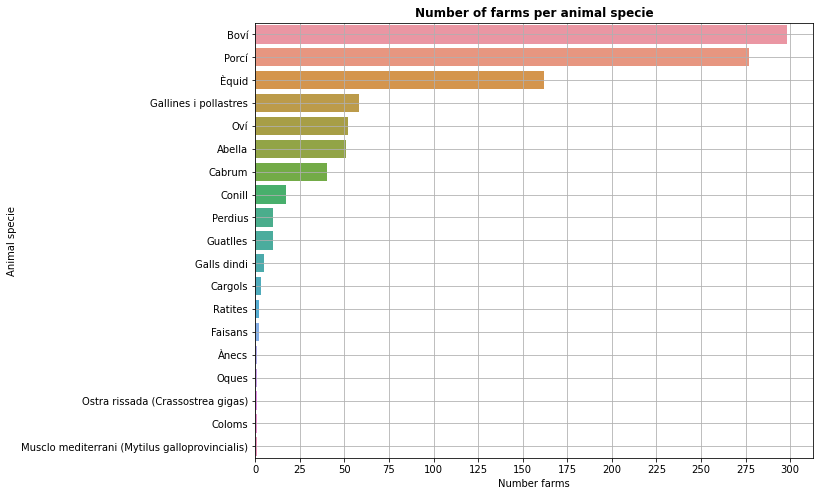

In [24]:
# Display the previous results
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
sns.barplot(x="Number farms", y="Animal", data=fav_species, ax=ax)
ax.xaxis.set_major_locator(ticker.MultipleLocator(25))
ax.grid()
ax.set_ylabel('Number of farms')
ax.set_ylabel('Animal specie')
ax.set_title('Number of farms per animal specie', weight='bold')
plt.show();

It can clearly be seen from the graph that the top 5 most frequent animals in farms are cows, pigs, horses, chickens & hens and sheeps. However, it is difficult to see what is the amount of farms for the top least frequent animals, so let's isolate the dataframe to only displant those.

In [25]:
# Store and show only the top 5 least frequent animals in farms
least_5fav_species = fav_species[-5:]
least_5fav_species

Animal  Number farms
14                                           Ànecs             1
15                                           Oques             1
16               Ostra rissada (Crassostrea gigas)             1
17                                          Coloms             1
18  Musclo mediterrani (Mytilus galloprovincialis)             1

The least 5 frequent animals in farms are geese, pigeons, Crassostrea gigas, mediterranean mussel (Mytilus galloprovincialis) and ducks. From all of those there is only one farm in Catalunya. 

## 5.2. Are there differences on animal species based on the province?

In [26]:
# Count the number of farms per animal per province and store it as a dataframe
df_specie_county = df.groupby(['demarcaci_territorial', 'esp_cie']).size().reset_index(name='Number farms')
df_specie_county.head(10)

demarcaci_territorial                esp_cie  Number farms
0             Barcelona                 Abella             2
1             Barcelona                   Boví             2
2             Barcelona                 Cabrum             2
3             Barcelona                 Conill             6
4             Barcelona  Gallines i pollastres             2
5             Barcelona                    Oví             4
6             Barcelona                  Porcí             8
7             Barcelona                  Èquid            15
8                Girona                 Abella             4
9                Girona                   Boví            13

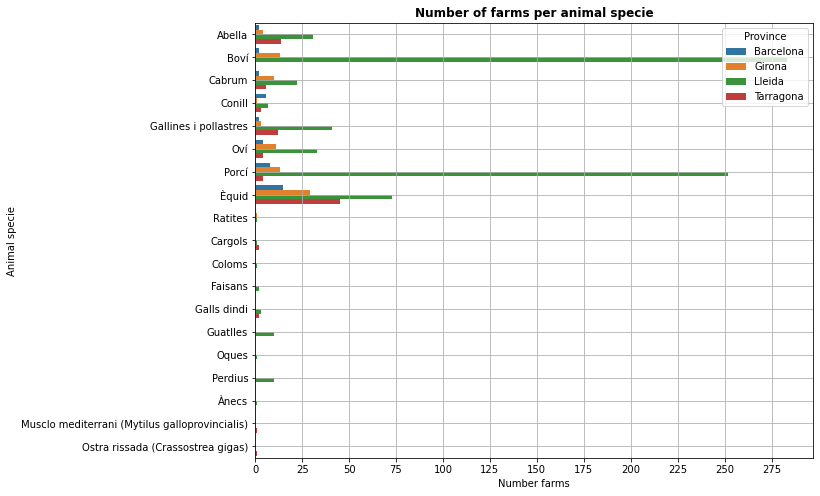

In [27]:
# Display the previous results
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
sns.barplot(x="Number farms", y="esp_cie", data=df_specie_county, ax=ax, hue="demarcaci_territorial")
ax.xaxis.set_major_locator(ticker.MultipleLocator(25))
ax.grid()
ax.set_ylabel('Number of farms')
ax.set_ylabel('Animal specie')
ax.set_title('Number of farms per animal specie', weight='bold')
plt.legend(title='Province')
plt.show();

It can be seen from the graph above that most of the farms are located in Lleida. Let´s have a closer look creating plots per the different countys. 

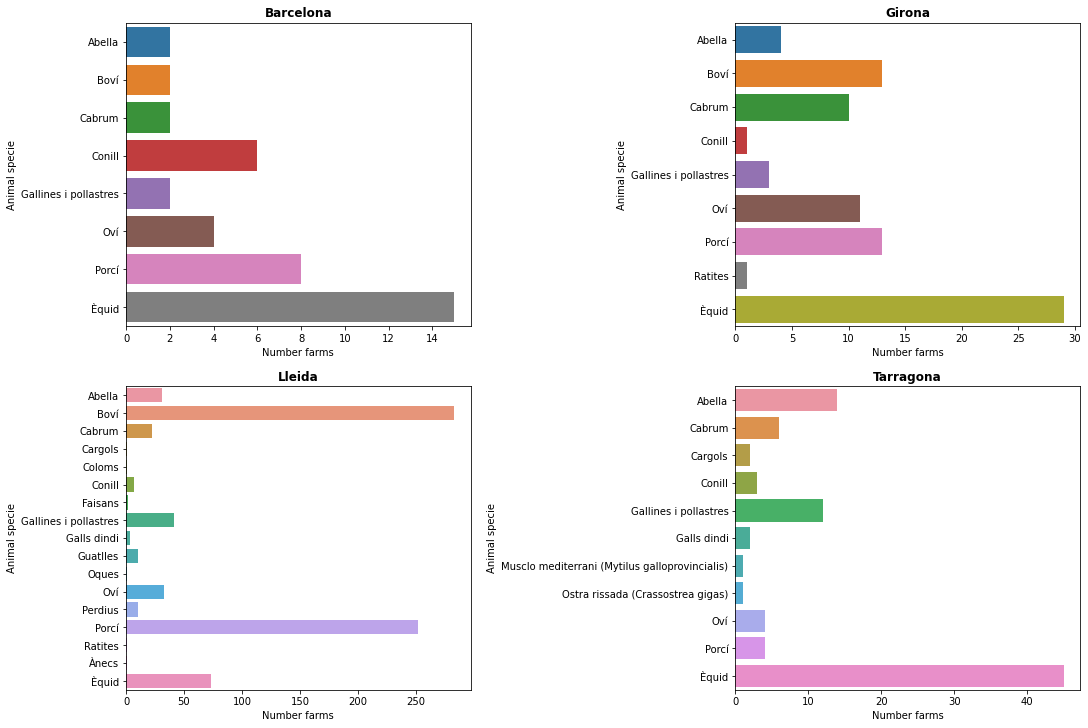

In [28]:
# Create the plots for the 4 countys
fig, ax = plt.subplots(2,2, constrained_layout=True)
fig.set_size_inches(15, 10)
 # to avoid plots overlapping

# Barcelona
sns.barplot(x="Number farms", y="esp_cie", data=df_specie_county.query('demarcaci_territorial == "Barcelona"'), ax=ax[0,0])
ax[0,0].set_title('Barcelona', weight='bold')
ax[0,0].set_ylabel('Animal specie')

# Girona
sns.barplot(x="Number farms", y="esp_cie", data=df_specie_county.query('demarcaci_territorial == "Girona"'), ax=ax[0,1])
ax[0,1].set_title('Girona', weight='bold')
ax[0,1].set_ylabel('Animal specie')

# Lleida
sns.barplot(x="Number farms", y="esp_cie", data=df_specie_county.query('demarcaci_territorial == "Lleida"'), ax=ax[1,0])
ax[1,0].set_title('Lleida', weight='bold')
ax[1,0].set_ylabel('Animal specie')

# Tarragona
sns.barplot(x="Number farms", y="esp_cie", data=df_specie_county.query('demarcaci_territorial == "Tarragona"'), ax=ax[1,1])
ax[1,1].set_title('Tarragona', weight='bold')
ax[1,1].set_ylabel('Animal specie')
plt.show();

In [29]:
# Let´s count the amount of farms per county and the percentage
county_farms = df.demarcaci_territorial.value_counts(sort=True).rename_axis('Province').reset_index(name='Number farms')
total_num_farms = county_farms['Number farms'].sum()
county_farms["Percentage farms"] = county_farms['Number farms'] / total_num_farms * 100
county_farms

Province  Number farms  Percentage farms
0     Lleida           772         77.822581
1  Tarragona            94          9.475806
2     Girona            85          8.568548
3  Barcelona            41          4.133065

There are huge differences on the amount of farms per province and the types of animals:
- **Lleida** has 77.8% of the farms, which are mostly cows and pigs.
- **Girona** has mostly horses, followed by pigs, cows, goats and sheeps.
- **Tarragona** has also mostly horses, with some bees and chicken farms. 
- **Barcelona** has mostly horses, followed by pigs and rabbits. 

## 5.3. How many organic farms are and what are the most frequent species?

In [30]:
# Check again the amount of organic farms (ecològic)
df.criteri_de_sostenibilitat.value_counts()

Convencional    960
Ecològic         22
Integrat          1
Name: criteri_de_sostenibilitat, dtype: int64

In [31]:
# Check the percentage
df.criteri_de_sostenibilitat.value_counts(normalize=True)

Convencional    0.976602
Ecològic        0.022380
Integrat        0.001017
Name: criteri_de_sostenibilitat, dtype: float64

In [32]:
# Store in a df only the organic farms
organic_farms = df.query('criteri_de_sostenibilitat == "Ecològic"')
organic_farms.esp_cie.value_counts(sort=True).rename_axis('Animal ').reset_index(name='Number farms')

Animal   Number farms
0                   Boví             7
1                 Cabrum             5
2                    Oví             5
3                  Porcí             3
4                 Abella             1
5  Gallines i pollastres             1

Only 2.2% of the farms (22 out of 992) are organic, which are mostly cows, goats and sheeps.

## 5.4. Where are the organic farms located?

In this last section, we will open two geojson that contains the provinces and regrions from Catalunya to visualize them in the Leaflet map with icons that will display a popup with some information about the farm. 

In [33]:
# Open geojson with the provinces
province_path = r"provincias-espanolas.geojson"
province_df = gpd.read_file(province_path)
province_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   provincia  52 non-null     object  
 1   texto      52 non-null     object  
 2   ccaa       52 non-null     object  
 3   codigo     52 non-null     object  
 4   cod_ccaa   52 non-null     object  
 5   geometry   52 non-null     geometry
dtypes: geometry(1), object(5)
memory usage: 2.6+ KB


In [34]:
#Select only the provinces from Catalunya
catalunya_df = province_df.query('ccaa == "Cataluña"')
catalunya_df.head()

provincia      texto      ccaa codigo cod_ccaa  \
22     Lleida     Lleida  Cataluña     25       09   
26  Barcelona  Barcelona  Cataluña     08       09   
39     Girona     Gerona  Cataluña     17       09   
42  Tarragona  Tarragona  Cataluña     43       09   

                                             geometry  
22  MULTIPOLYGON (((1.71565 41.89214, 1.71863 41.8...  
26  MULTIPOLYGON (((1.65707 42.11443, 1.66435 42.1...  
39  MULTIPOLYGON (((2.79274 41.67061, 2.79235 41.6...  
42  MULTIPOLYGON (((0.85208 40.72511, 0.85267 40.7...

In [35]:
# Open geojson with the regions per province of Catalunya
region_path = r"catalunya_comarcas.geojson"
region_df = gpd.read_file(region_path)
region_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   cartodb_id  41 non-null     int64   
 1   comarca     41 non-null     int64   
 2   provincia   41 non-null     object  
 3   nom_comar   41 non-null     object  
 4   sup_comar   41 non-null     float64 
 5   geometry    41 non-null     geometry
dtypes: float64(1), geometry(1), int64(2), object(2)
memory usage: 2.0+ KB


The dataset with the information of the farms contains the information about the latitude and the longitude in columns coor_x and coor_y, but they are stored in separated columns and not in the correct format for visualization because they are in UTM and we need them in WSG 84.

To solve that:
- Extract the latitude and longitude in decimal format from the 'latitud' and 'longitud' columns, which are in DSM format.
- Convert the dataframe to a geodataframe by adding as geometry the point coordinates from latitude and longitud. Important that the longitud is the 'x' argument and that latitude is the 'y' argument.  

In [36]:
# Extract the days, min and seconds
pattern = r'(?P<d>[\d\.]+).*?(?P<m>[\d\.]+).*?(?P<s>[\d\.]+)'

# from the latitud column to store it in the proper format
dms_lat = organic_farms['latitud'].str.extract(pattern)
dms_lat = dms_lat.astype(float)
organic_farms['lat'] = (dms_lat['d'] + dms_lat['m'].div(60) + dms_lat['s'].div(3600))

# and from the longitud column to store it in the proper format
dms_long = organic_farms['longitud'].str.extract(pattern)
dms_long = dms_long.astype(float)
organic_farms['long'] = (dms_long['d'] + dms_long['m'].div(60) + dms_long['s'].div(3600))

# Display the new columns to check that the values make sense
organic_farms[['lat', 'long']].head()

C:\Users\Marina\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\Marina\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


lat      long
7   42.150814  1.077159
8   42.150814  1.077159
77  42.013102  0.785380
78  42.013102  0.785380
79  42.013102  0.785380

In [37]:
# Convert organic_farms dataframe to a geodataframe
organic_farms["geometry"] = organic_farms.apply(lambda x: Point((x.long, x.lat)), axis=1)
crs = {'init': 'epsg:4326'}
organic_farms_gdf = gpd.GeoDataFrame(organic_farms, crs=crs, geometry=organic_farms.geometry)
organic_farms_gdf.crs

C:\Users\Marina\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Marina\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [38]:
m = folium.Map(location=[41.916444, 2.268789], zoom_start=8)

for row in organic_farms.iterrows():
    row_values = row[1]
    location = [row_values['lat'], row_values['long']]
    info = '<strong>' + row_values['nom_explotaci'] + '</strong>' + '<br>' + "Farm specie: " + row_values['esp_cie']\
        + '<br>' + "Region: " + row_values['comarca'] + '<br>' + "Municipality: " + row_values['municipi']
    iframe = folium.IFrame(info)
    popup = folium.Popup(iframe, min_width=200, max_width=300)  
    marker = folium.Marker(location = location, popup = popup)
    marker.add_to(m)

style_provinces = {'fillColor': 'grey', 'color': 'black', 'opacity':0.2}
style_regions = {'fillColor': '#00FFFFFF', 'color': 'blue', 'opacity':0.2}
folium.GeoJson(region_df, name="Catalunya regions", style_function=lambda x:style_regions).add_to(m)
folium.GeoJson(catalunya_df, name="Catalunya provinces", style_function=lambda x:style_provinces).add_to(m)
folium.LayerControl(collapsed=False).add_to(m)

display(m)